In [1]:
import datetime as dt
from tracker.tracker import get_owned
from optimizer.ingestion import get_data
from optimizer.optimization import plot_results

In [2]:
# assets = get_owned()
assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'SOL1-USD']
# assets = ['CEVA', 'GOOGL', 'TSLA', 'ZOM']

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)

# start_date = dt.date(2021, 1, 1)
# end_date = dt.date(2021, 1, 23)

mean_returns, cov_matrix, delta_days = get_data(assets, start_date, end_date, log=False)

[*********************100%***********************]  4 of 4 completed


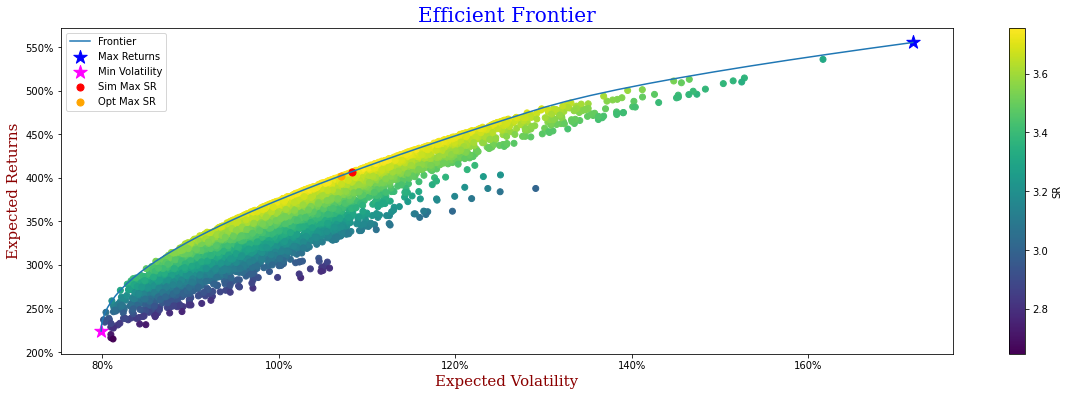

Max Returns: [{'SOL1': 100.0}]
Min Volatility: [{'BTC': 2.3}, {'ETH': 91.0}, {'SOL1': 6.7}]
Sim Max SR: [{'BTC': 35.8}, {'ETH': 24.6}, {'ADA': 0.4}, {'SOL1': 39.2}]
Opt Max SR: [{'BTC': 33.6}, {'ETH': 27.2}, {'SOL1': 39.3}]


In [3]:
plot_results(mean_returns, cov_matrix, delta_days, assets)